<a href="https://colab.research.google.com/github/kwcooper/CL_neuromatch/blob/main/continual_learning_neuromatch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


# Neuromatch Academy: Week ?, Day ?, Tutorial ?
# Introduction to Continual Learning

__Content creators:__ [Keiland Cooper](http://kwcooper.xyz), [Diganta Misra](https://digantamisra98.github.io/), [Vincenzo Lomonaco](https://www.vincenzolomonaco.com/), [Gido van de Ven](https://www.bcm.edu/people-search/gido-van-de-ven-32297), Andrea Cossu


__Content reviewers:__ Name Surname, Name Surname. This includes both reviewers and editors. 


In [ ]:
#@title Video 0: Overview of the session and introduction to continual learning [to be created]
# Insert the ID of the corresponding youtube video
from IPython.display import YouTubeVideo
video = YouTubeVideo(id="", width=854, height=480, fs=1)
print("Video available at https://youtu.be/" + video.id)
video


Video available at https://youtu.be/


---
#Tutorial Objectives



(Will update)
In this tutorial we'll dive head-first into the exciting field of continual learning (CL). CL has gained increasing attention in recent years, and for good reason. CL is postioned as a problem accross sub-disaplanes, from academia and industry, and may promise to be a major pathway towards strong artificial intelligence. As datasets get bigger and AI gets smarter, we're expecting more and more cognitive capabilities from our machines. 

We have a few specific objectives for this tutorial:
*   Introduce students to major CL concepts
*   Introduce the most common strategies to aid CL
*   Utilize benchmarks and evaluation metrics 
*   Explore present day applications of CL 


_Use a line (---) separator from title block to objectives. You should briefly introduce your content here in a few sentences. In this tutorial, you will learn what a waxed notebook should look like. **You should make sure the notebook runs from start to finish when done waxing (do restart and run all and make sure there are no errors)**_



---
# Setup

First, let's load in some usefule packages and functions. We'll primarly be using PyTorch as our neural network framework of choice. Be sure to run all the cells below so the code runs properly. 

In [ ]:
# Imports 

import numpy as np
import matplotlib.pyplot as plt

import torch # should work natively now 
import torch.nn as nn
import torchvision.datasets as datasets
import torchvision.transforms as transforms
import torch.optim as optim
import torch.nn.functional as F


In [ ]:
#@title Figure settings
import ipywidgets as widgets       # interactive display
%config InlineBackend.figure_format = 'retina'
plt.style.use("https://raw.githubusercontent.com/NeuromatchAcademy/course-content/master/nma.mplstyle")

In [ ]:
#@title Configure PyTorch

# PyTorch Configuration
print('Torch', torch.__version__, 'CUDA', torch.version.cuda)

if not torch.cuda.is_available():
  print('For quicker runtime, add GPU at Runtime -> Change runtime type -> Hardware accelerator -> GPU')

else:
  # switch to False to use CPU
  use_cuda = True

  use_cuda = use_cuda and torch.cuda.is_available()
  device = torch.device("cuda" if use_cuda else "cpu");

# set the seed
torch.manual_seed(1);

Torch 1.8.1+cu101 CUDA 10.1


In [ ]:
#@title Data-loader Helper functions (MNIST and core50)

# TODO:
# We need a more permenate solution for this... 
# https://github.com/pytorch/vision/issues/1938

# we should also probably supress most of this output 
# unless we change the source of the data

print('Downloading and unpacking MNIST data. Please wait a moment...\n')

# The MNIST repo on LeCun's website nor AWS seem to be availible
# This is one popular private repo, but beware
# PyTorch is reported to be hosting one soon...
!wget www.di.ens.fr/~lelarge/MNIST.tar.gz
!tar -zxvf MNIST.tar.gz

from torchvision.datasets import MNIST
from torchvision import transforms

mnist_train = MNIST('./', download=False,
                    transform=transforms.Compose([
                        transforms.ToTensor(),
                    ]), train=True)
mnist_test = MNIST('./', download=False,
                    transform=transforms.Compose([
                        transforms.ToTensor(),
                    ]), train=False)

def load_mnist(verbose=False, asnumpy=True):
    '''
    Helper function to maintain compatability with
    previous MNIST dataloaders in CLAI COLAB

    Much of this can likely now be fixed with the toTensor call on inport
    Or by using proper PyTorch functions... lol

    - KWC
    '''
    
    x_traint, t_traint = mnist_train.data, mnist_train.targets
    x_testt, t_testt = mnist_test.data, mnist_test.targets
    
    if asnumpy: 
      # Fix dimensions and convert back to np array for code compatability
      # We aren't using torch dataloaders for ease of use
      x_traint = torch.unsqueeze(x_traint, 1)
      x_testt = torch.unsqueeze(x_testt, 1)
      x_train, x_test = x_traint.numpy().copy(), x_testt.numpy()
      t_train, t_test = t_traint.numpy().copy(), t_testt.numpy()
    else:
      x_train, t_train = x_traint, t_traint
      x_test, t_test = x_testt, t_testt

    if verbose: 
      print("x_train dim and type: ", x_train.shape, x_train.dtype)
      print("t_train dim and type: ", t_train.shape, t_train.dtype)
      print("x_test dim and type: ", x_test.shape, x_test.dtype)
      print("t_test dim and type: ", t_test.shape, t_test.dtype)
      print()


    return x_train, t_train, x_test, t_test

print('\nDownloading core50 in the background...')
# this lines of code will download core50 in background. We suggest to run it at the start of the notebook
!wget http://raw.githubusercontent.com/ContinualAI/colab/master/scripts/download_and_extract_core50_mini.sh
!nohup sh download_and_extract_core50_mini.sh &

print('Core50 will be silently unpacked in the backgroud. Please continue.')


--2021-06-03 13:24:25--  http://www.di.ens.fr/~lelarge/MNIST.tar.gz
Resolving www.di.ens.fr (www.di.ens.fr)... 129.199.99.14
Connecting to www.di.ens.fr (www.di.ens.fr)|129.199.99.14|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://www.di.ens.fr/~lelarge/MNIST.tar.gz [following]
--2021-06-03 13:24:26--  https://www.di.ens.fr/~lelarge/MNIST.tar.gz
Connecting to www.di.ens.fr (www.di.ens.fr)|129.199.99.14|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified [application/x-gzip]
Saving to: ‘MNIST.tar.gz’

MNIST.tar.gz            [         <=>        ]  33.20M  17.4MB/s    in 1.9s    

2021-06-03 13:24:28 (17.4 MB/s) - ‘MNIST.tar.gz’ saved [34813078]

MNIST/
MNIST/raw/
MNIST/raw/train-labels-idx1-ubyte
MNIST/raw/t10k-labels-idx1-ubyte.gz
MNIST/raw/t10k-labels-idx1-ubyte
MNIST/raw/t10k-images-idx3-ubyte.gz
MNIST/raw/train-images-idx3-ubyte
MNIST/raw/train-labels-idx1-ubyte.gz
MNIST/raw/t10k-images-idx3-ubyte
MNIST/raw/tr

In [ ]:
#@title Plotting and Utils Helper functions

# If any helper functions you want to hide for clarity, add here
# If helper code depends on libraries that aren't used elsewhere,
# import those libaries here, rather than in the main import cell


def plot_mnist(data, nPlots=10):
  """ Plot MNIST-like data """
  f, axarr = plt.subplots(1,nPlots)
  for ii in range(nPlots):
    axarr[ii].imshow(data[ii,0], cmap="gray")
  np.vectorize(lambda ax:ax.axis('off'))(axarr);
  plt.show()


def permute_mnist(mnist, seed, verbose=False):
    """ Given the training set, permute pixels of each img the same way. """

    np.random.seed(seed)
    if verbose: print("starting permutation...")
    h = w = 28
    perm_inds = list(range(h*w))
    np.random.shuffle(perm_inds)
    # print(perm_inds)
    perm_mnist = []
    for set in mnist:
        num_img = set.shape[0]
        flat_set = set.reshape(num_img, w * h)
        perm_mnist.append(flat_set[:, perm_inds].reshape(num_img, 1, w, h))
    if verbose: print("done.")
    return perm_mnist


def multi_task_barplot(accs, tasks, t=None):
  ''' Plot n task accuracy
      used for S1 intro to CF code '''
  nTasks = len(accs)
  plt.bar(range(nTasks), accs, color='k')
  plt.ylabel('Testing Accuracy (%)', size=18)
  plt.xticks(range(nTasks), 
            [f'{TN}\nTask {ii+1}' for ii,TN in enumerate(tasks.keys())], 
            size=18)
  plt.title(t)


def plot_task(axs, data, samples_num):
  for sample in range(samples_num):
    axs[sample].imshow(data[sample][0], cmap="gray")
    # np.vectorize(lambda ax:ax.axis('off'))(axs[sample]);
    axs[sample].xaxis.set_ticks([])
    axs[sample].yaxis.set_ticks([])


---

# Section 1: The sequential learning problem: catastrophic forgetting 

In [ ]:
#@title Video 1: Introduction to catastrophic forgetting [to be created]
# Insert the ID of the corresponding youtube video
from IPython.display import YouTubeVideo
video = YouTubeVideo(id="", width=854, height=480, fs=1)
print("Video available at https://youtu.be/" + video.id)
video


Video available at https://youtu.be/


Here we'll explore catastrophic forgetting first hand, a key barrier preventing continual learning in neural networks. To do so, we'll build a simple network model and try our best to teach it the trusty MNIST dataset

## Section 1.1: A brief example of catastrophic forgetting 

Let's define a simple CNN that can perform fairly well on MNIST. We'll also load in some training and testing functions we wrote to load the data into the model and train / test it. We don't need to get into the details how they work for now (pretty standard) but feel free to double click the cell if you're curious!

In [ ]:
# Here we define a simple multilayer CNN. Nothing too fancy
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 10, kernel_size=5)
        self.conv2 = nn.Conv2d(10, 20, kernel_size=5)
        self.conv2_drop = nn.Dropout2d()
        self.fc1 = nn.Linear(320, 50)
        self.fc2 = nn.Linear(50, 10)

    def forward(self, x):
        """ run the network forward 
        (uses the functional library (F) imported from pytorch)"""
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        x = F.relu(F.max_pool2d(self.conv2_drop(self.conv2(x)), 2))
        x = x.view(-1, 320)
        x = F.relu(self.fc1(x))
        x = F.dropout(x, training=self.training)
        x = self.fc2(x)
        return x

In [ ]:
#@title [RUN ME!] Model Training and Testing Functions
def train(model, device, x_train, t_train, optimizer, epoch):
    """

    """
    model.train()
    
    for start in range(0, len(t_train)-1, 256):
      end = start + 256
      x = torch.from_numpy(x_train[start:end]).type(torch.cuda.FloatTensor)
      y = torch.from_numpy(t_train[start:end]).long()
      x, y = x.to(device), y.to(device)
      
      optimizer.zero_grad()

      output = model(x)
      loss = F.cross_entropy(output, y)
      loss.backward()
      optimizer.step()
      #print(loss.item())
    print('Train Epoch: {} \tLoss: {:.6f}'.format(epoch, loss.item()))

def test(model, device, x_test, t_test):
    """

    """
    model.eval()
    correct, test_loss = 0, 0
    for start in range(0, len(t_test)-1, 256):
      end = start + 256
      with torch.no_grad():
        x = torch.from_numpy(x_test[start:end]).type(torch.cuda.FloatTensor)
        y = torch.from_numpy(t_test[start:end]).long()
        x, y = x.to(device), y.to(device)
        output = model(x)
        test_loss += F.cross_entropy(output, y).item() # sum up batch loss
        pred = output.max(1, keepdim=True)[1] # get the index of the max logit
        correct += pred.eq(y.view_as(pred)).sum().item()

    test_loss /= len(t_train)
    print('Test set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(t_test),
        100. * correct / len(t_test)))
    return 100. * correct / len(t_test)


class simpNet(nn.Module):
    def __init__(self):
        super(simpNet,self).__init__()
        self.linear1 = nn.Linear(28*28, 320) 
        #self.linear2 = nn.Linear(320, 50) 
        self.out = nn.Linear(320, 10)
        self.relu = nn.ReLU()

    def forward(self, img): 
        #print(img.shape)
        x = img.view(-1, 28*28)
        #print(x.shape)
        x = self.relu(self.linear1(x))
        #x = self.relu(self.linear2(x))
        x = self.out(x)
        return x


Now let's load in our dataset, MNIST. We'll also run a function we defined in the helper function cell above that permutes (scrambles) the images. This allows us to create aditional datasets with similar statictics to MNIST on the fly. We'll call the normal MNIST Task 1, and the permuted MNIST Task 2. We'll see why in a second!

x_train dim and type:  (60000, 1, 28, 28) uint8
t_train dim and type:  (60000,) int64
x_test dim and type:  (10000, 1, 28, 28) uint8
t_test dim and type:  (10000,) int64

Task 1: MNIST Training data:


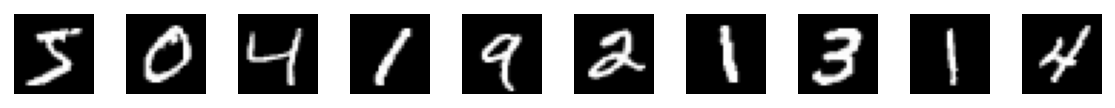


Task 2: Permuted MNIST data:


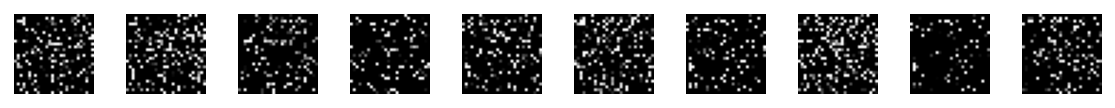

In [ ]:
# Load in MNIST and create an additional permuted dataset
x_train, t_train, x_test, t_test = load_mnist(verbose=True)
x_train2, x_test2 = permute_mnist([x_train, x_test], 0, verbose=False)

# Plot the data to see what we're working with
print('Task 1: MNIST Training data:')
plot_mnist(x_train, nPlots=10)
print('\nTask 2: Permuted MNIST data:')
plot_mnist(x_train2, nPlots=10)


Great! We have our data. Now, let's initialize and train our model on the standard MNIST dataset (Task 1) and make sure everything is working properly. 

In [ ]:
# Define a new model and set params
model = Net().to(device)
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)

# Train the model on MNIST
nEpochs = 3 
print(f'Training model on {nEpochs} epochs...')
for epoch in range(1, nEpochs+1):
  train(model, device, x_train, t_train, optimizer, epoch)
  test(model, device, x_test, t_test)

Training model on 3 epochs...
Train Epoch: 1 	Loss: 1.531727
Test set: Average loss: 0.0004, Accuracy: 8701/10000 (87%)

Train Epoch: 2 	Loss: 0.809245
Test set: Average loss: 0.0002, Accuracy: 9280/10000 (93%)

Train Epoch: 3 	Loss: 1.077803
Test set: Average loss: 0.0001, Accuracy: 9363/10000 (94%)



Okay great! It seems we get decent accuracy on standard MNIST which means the model is learning our dataset. Now, a reasonable assumption is that, like humans, once the network learns something, it can aggregate its knowledge and learn something else. 

First, let's get a baseline for how the model performs on the dataset it was just trained on (Task 1) as well as to see how well it performs on a new dataset (Task 2). 

Testing on task 1
Test set: Average loss: 0.0001, Accuracy: 9363/10000 (94%)

Testing on task 2
Test set: Average loss: 0.0019, Accuracy: 782/10000 (8%)



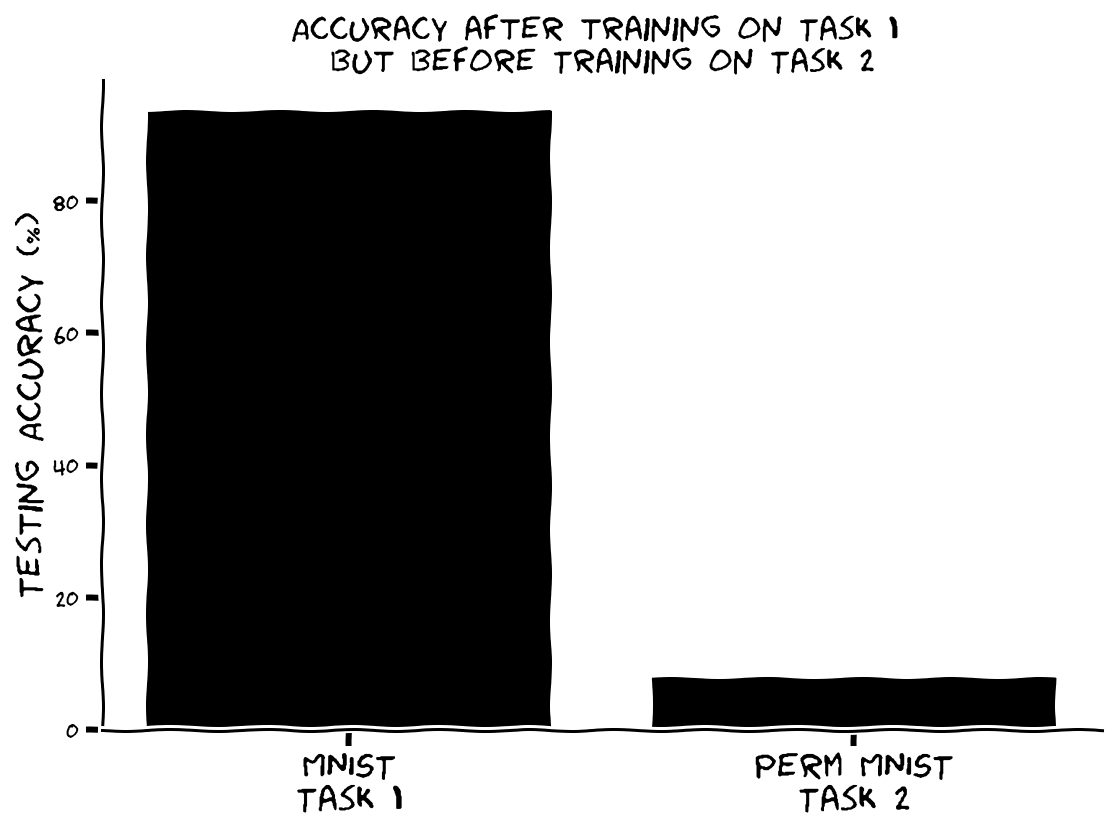

In [ ]:
# test the model's accuracy on both the regular and permuted dataset

# Let's define a dictionary that holds each of the task
# datasets and labels 
tasks = {'MNIST':(x_test, t_test), 
         'Perm MNIST':(x_test2, t_test)}
t1_accs = []
for ti, task in enumerate(tasks.keys()):
  print(f"Testing on task {ti+1}")
  t1_accs.append(test(model, device, tasks[task][0], tasks[task][1]))

# And then let's plot the testing accuracy on both datasets
with plt.xkcd():  
  multi_task_barplot(t1_accs, tasks, 
                     t='Accuracy after training on Task 1 \nbut before Training on Task 2')


As we saw before, the model does great on the Task 1 dataset it was trained on, but not so well on the new one. No worries! We havn't taught it the permuted MNIST dataset yet! So let's train the *same* task 1-trained-model on the new data, and see if we can get comparable performance between the two types of MNIST

Train Epoch: 1 	Loss: 1.499048
Test set: Average loss: 0.0006, Accuracy: 7450/10000 (74%)

Train Epoch: 2 	Loss: 1.277805
Test set: Average loss: 0.0005, Accuracy: 7921/10000 (79%)

Testing on task 1
Test set: Average loss: 0.0015, Accuracy: 1226/10000 (12%)

Testing on task 2
Test set: Average loss: 0.0005, Accuracy: 7921/10000 (79%)



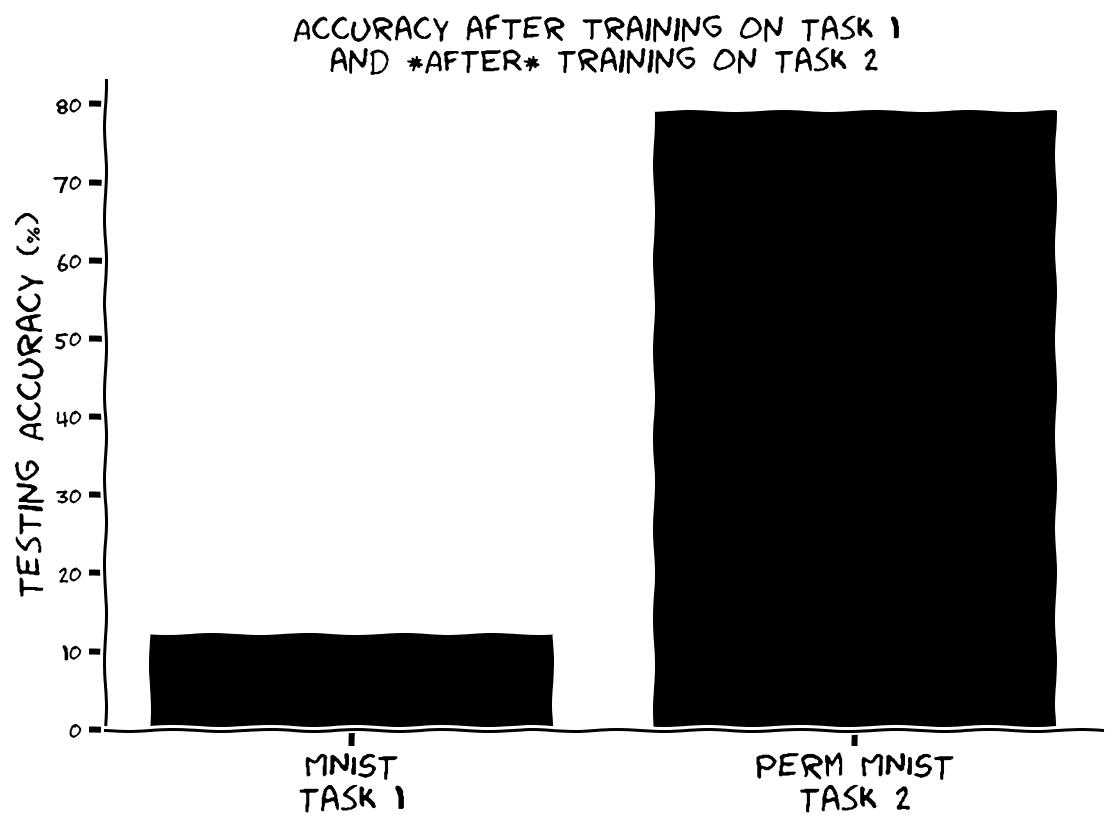

In [ ]:

# Train the previously trained model on Task 2, the permuted MNIST dataset
for epoch in range(1, 3):
  train(model, device, x_train2, t_train, optimizer, epoch)
  test(model, device, x_test2, t_test)

# Same data as before, stored in a dict
tasks = {'MNIST':(x_test, t_test), 
         'Perm MNIST':(x_test2, t_test)}
# Test the model on both datasets, same as before
t12_accs = []
for ti, task in enumerate(tasks.keys()):
  print(f"Testing on task {ti+1}")
  t12_accs.append(test(model, device, tasks[task][0], tasks[task][1]))

# And then let's plot each of the testing accuracies after the new training
with plt.xkcd():  
  multi_task_barplot(t12_accs, tasks, 
                     t='Accuracy after training on Task 1 \nand *AFTER* Training on Task 2')


Hey! Training did the trick, task 2 (permuted MNIST) has great accuracy now that we trained the model on it. But something is wrong. We just saw that Task 1 (standard MNIST) had high accuracy before we trained on the new task. What gives? Try to incorperate what you learned in the lecture to help explain the problem we're seeing. You might also take a few seconds and think of what possible soultions you might like to try. In the next section, we'll look into exactly that!

## Section 1.2: Name

### Exercise 2: Name

---
# Section 2: Continual Learning strategies

## Split MNIST

For this section we will again use the MNIST dataset, but we will now create 5 tasks by splitting the dataset up in such a way that each task contains 2 classes. This problem is called Split MNIST, and it is popular toy problem in the continual learning literature

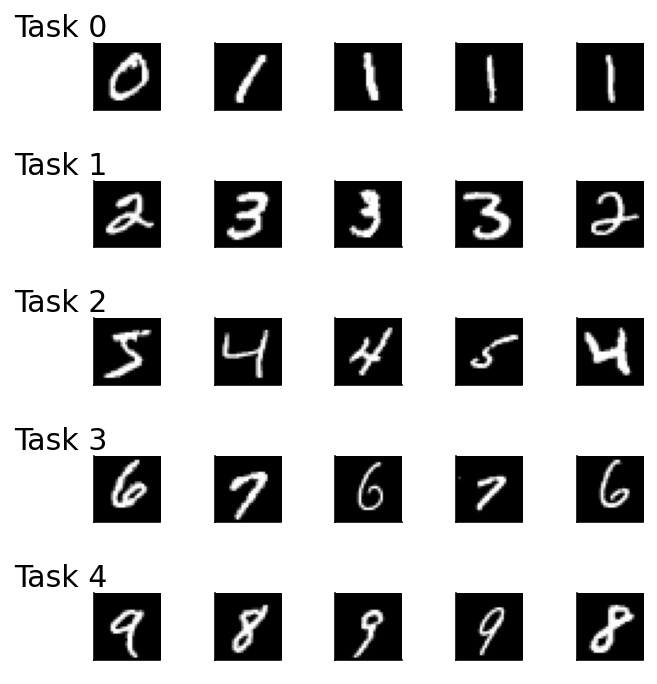

In [ ]:
# Specify which classes should be part of which task
task_classes_arr = [(0, 1), (2, 3), (4, 5), (6, 7), (8, 9)]
tasks_num = len(task_classes_arr) # 5

# Divide the data over the different tasks
task_data_with_overlap = []
for task_id, task_classes in enumerate(task_classes_arr):
  train_mask = np.isin(t_train, task_classes)
  test_mask = np.isin(t_test, task_classes)
  x_train_task, t_train_task = x_train[train_mask], t_train[train_mask]
  x_test_task, t_test_task = x_test[test_mask], t_test[test_mask]
  # Convert the original class labels (i.e., the digits 0 to 9) to
  # "within-task labels" so that within each task one of the digits is labelled
  # as '0' and the other as '1'.
  task_data_with_overlap.append((x_train_task, t_train_task - (task_id * 2),
                                 x_test_task, t_test_task - (task_id * 2)))

# Display tasks
n_tasks, samples = 5, 5
_, axs = plt.subplots(n_tasks, samples, figsize=(5, 5))
for task in range(n_tasks):
  axs[task, 0].set_ylabel(f'Task {task}', rotation=0)
  axs[task, 0].yaxis.set_label_coords(-0.5,1)
  plot_task(axs[task], task_data_with_overlap[task][0], samples)
plt.tight_layout()

## Naive strategy ("fine-tuning")
First, let's see what happens if we simply sequentially train a deep neural network on these tasks in the standard way.

Let's start by defining our network. As is common in the continual learning literature, we will use a "multi-headed layout". This means that we have a separate output layer for each task to be learned, but the hidden layers of the network are shared between all tasks.

In [ ]:
## Base network that is shared between all tasks
class FBaseNet(nn.Module):
  def __init__(self, hsize=512):
    super(FBaseNet, self).__init__()
    self.l1 = nn.Linear(784, hsize)

  def forward(self, x):
    x = x.view(x.size(0), -1)
    x = F.relu(self.l1(x))
    return x

## Output layer, which will be separate for each task
class FHeadNet(nn.Module):
  def __init__(self, base_net, input_size=512):
    super(FHeadNet, self).__init__()

    self.base_net = base_net
    self.output_layer = nn.Linear(input_size, 2)

  def forward(self, x):
    x = self.base_net.forward(x)
    x = self.output_layer(x)
    return x

In [ ]:
# Define the base network (a new head is defined when we encounter a new task)
base = FBaseNet().to(device)
heads = []

# Define a list to store test accuracies for each task
accs_naive = []

# Set the number of epochs to train each task for
epochs = 3

# Loop through all tasks
for task_id in range(tasks_num):
    # Collect the training data for the new task
    x_train, t_train, _, _ = task_data_with_overlap[task_id]

    # Define a new head for this task
    model = FHeadNet(base).to(device)
    heads.append(model)

    # Set the optimizer
    optimizer = optim.SGD(heads[task_id].parameters(), lr=0.01)

    # Train the model (with the new head) on the current task
    train(heads[task_id], device, x_train, t_train, optimizer, epochs)

    # Test the model on all tasks seen so far
    accs_subset = []
    for i in range(0, task_id + 1):
        _, _, x_test, t_test = task_data_with_overlap[i]
        test_acc = test(heads[i], device, x_test, t_test)
        accs_subset.append(test_acc)
    # For unseen tasks, we don't test
    if task_id < (tasks_num - 1):
        accs_subset.extend([np.nan] * (4 - task_id))
    # Collect all test accuracies
    accs_naive.append(accs_subset)

Train Epoch: 3 	Loss: 0.000515
Test set: Average loss: 0.0007, Accuracy: 2109/2115 (100%)

Train Epoch: 3 	Loss: 0.399739
Test set: Average loss: 0.0011, Accuracy: 1462/2115 (69%)

Test set: Average loss: 0.0004, Accuracy: 1040/2042 (51%)

Train Epoch: 3 	Loss: 0.072666
Test set: Average loss: 0.0018, Accuracy: 1667/2115 (79%)

Test set: Average loss: 0.0006, Accuracy: 994/2042 (49%)

Test set: Average loss: 0.0000, Accuracy: 1853/1874 (99%)

Train Epoch: 3 	Loss: 0.000197
Test set: Average loss: 0.0067, Accuracy: 1395/2115 (66%)

Test set: Average loss: 0.0003, Accuracy: 1376/2042 (67%)

Test set: Average loss: 0.0006, Accuracy: 1215/1874 (65%)

Test set: Average loss: 0.0000, Accuracy: 1958/1986 (99%)

Train Epoch: 3 	Loss: 0.350290
Test set: Average loss: 0.0014, Accuracy: 1477/2115 (70%)

Test set: Average loss: 0.0005, Accuracy: 1091/2042 (53%)

Test set: Average loss: 0.0017, Accuracy: 886/1874 (47%)

Test set: Average loss: 0.0002, Accuracy: 1744/1986 (88%)

Test set: Average lo

As you can see, whenever this network is trained on a new task, its performance on previously learned tasks drops substantially.

Now, let's see whether we can use a continual learning strategy to prevent such forgetting.

## Elastic Weight Consolidation (EWC)

EWC is a popular CL strategy which involves computing the importance of weights of the network relative to the task using the Fisher score and then penalizing the network for changes to the most important weights of the previous task. 

It was introduced in the paper "[Overcoming catastrophic forgetting in neural networks
](https://arxiv.org/abs/1612.00796)". 

For EWC, we need to define a new function to compute the fisher information matrix for each weight at the end of every task:

In [ ]:
def on_task_update(task_id, x_mem, t_mem, model, shared_model, fisher_dict,
                   optpar_dict):

  model.train()
  optimizer.zero_grad()
  
  # accumulating gradients
  for start in range(0, len(t_mem)-1, 256):
      end = start + 256
      x = torch.from_numpy(x_train[start:end]).type(torch.cuda.FloatTensor)
      y = torch.from_numpy(t_train[start:end]).long()
      x, y = x.to(device), y.to(device)
      output = model(x)
      loss = F.cross_entropy(output, y)
      loss.backward()

  fisher_dict[task_id] = {}
  optpar_dict[task_id] = {}

  # gradients accumulated can be used to calculate fisher
  for name, param in shared_model.named_parameters():
    optpar_dict[task_id][name] = param.data.clone()
    fisher_dict[task_id][name] = param.grad.data.clone().pow(2)

We also need to modify our train function to add the new regularization loss:

In [ ]:
def train_ewc(model, shared_model, device, task_id, x_train, t_train, optimizer,
              epoch, ewc_lambda, fisher_dict, optpar_dict):
    model.train()

    for start in range(0, len(t_train)-1, 256):
      end = start + 256
      x = torch.from_numpy(x_train[start:end]).type(torch.cuda.FloatTensor)
      y = torch.from_numpy(t_train[start:end]).long()
      x, y = x.to(device), y.to(device)
      
      optimizer.zero_grad()

      output = model(x)
      loss = F.cross_entropy(output, y)
      
      ### magic here! :-)
      for task in range(task_id):
        for name, param in shared_model.named_parameters():
          fisher = fisher_dict[task][name]
          optpar = optpar_dict[task][name]
          loss += (fisher * (optpar - param).pow(2)).sum() * ewc_lambda
      
      loss.backward()
      optimizer.step()
      #print(loss.item())
    print('Train Epoch: {} \tLoss: {:.6f}'.format(epoch, loss.item()))

Now let's train with EWC:

In [ ]:
# Define the base network (a new head is defined when we encounter a new task)
base = FBaseNet().to(device)
heads = []

# Define a list to store test accuracies for each task
accs_ewc = []

# Set number of epochs
epochs = 2

# Set EWC hyperparameter
ewc_lambda = 0.4

# Define dictionaries to store values needed by EWC
fisher_dict = {}
optpar_dict = {}

# Loop through all tasks
for task_id in range(tasks_num):
    # Collect the training data for the new task
    x_train, t_train, _, _ = task_data_with_overlap[task_id]

    # Define a new head for this task
    model = FHeadNet(base).to(device)
    heads.append(model)

    # Set the optimizer
    optimizer = optim.SGD(heads[task_id].parameters(), lr=0.01)

    # Train the model (with the new head) on the current task
    for epoch in range(1, epochs+1):
        train_ewc(heads[task_id], heads[task_id].base_net, device, task_id,
                  x_train, t_train, optimizer, epoch, ewc_lambda, fisher_dict,
                  optpar_dict)
    on_task_update(task_id, x_train, t_train, heads[task_id],
                   heads[task_id].base_net, fisher_dict, optpar_dict)

    # Test the model on all tasks seen so far
    accs_subset = []
    for i in range(0, task_id + 1):
        _, _, x_test, t_test = task_data_with_overlap[i]
        test_acc = test(heads[i], device, x_test, t_test)
        accs_subset.append(test_acc)
    # For unseen tasks, we don't test
    if task_id < (tasks_num - 1):
        accs_subset.extend([np.nan] * (4 - task_id))
    # Collect all test accuracies
    accs_ewc.append(accs_subset)

Train Epoch: 1 	Loss: 0.000038
Train Epoch: 2 	Loss: 0.000082
Test set: Average loss: 0.0000, Accuracy: 2113/2115 (100%)

Train Epoch: 1 	Loss: 0.244842
Train Epoch: 2 	Loss: 0.171106
Test set: Average loss: 0.0000, Accuracy: 2090/2115 (99%)

Test set: Average loss: 0.0000, Accuracy: 1986/2042 (97%)

Train Epoch: 1 	Loss: 0.484683
Train Epoch: 2 	Loss: 0.279049
Test set: Average loss: 0.0009, Accuracy: 1875/2115 (89%)

Test set: Average loss: 0.0002, Accuracy: 1880/2042 (92%)

Test set: Average loss: 0.0000, Accuracy: 1862/1874 (99%)

Train Epoch: 1 	Loss: 1.238728
Train Epoch: 2 	Loss: 0.631209
Test set: Average loss: 0.0002, Accuracy: 1995/2115 (94%)

Test set: Average loss: 0.0006, Accuracy: 1063/2042 (52%)

Test set: Average loss: 0.0004, Accuracy: 1224/1874 (65%)

Test set: Average loss: 0.0000, Accuracy: 1974/1986 (99%)

Train Epoch: 1 	Loss: 0.813502
Train Epoch: 2 	Loss: 0.795714
Test set: Average loss: 0.0003, Accuracy: 1868/2115 (88%)

Test set: Average loss: 0.0012, Accuracy

Text(0.5, 12.200000000000024, 'Task Number')

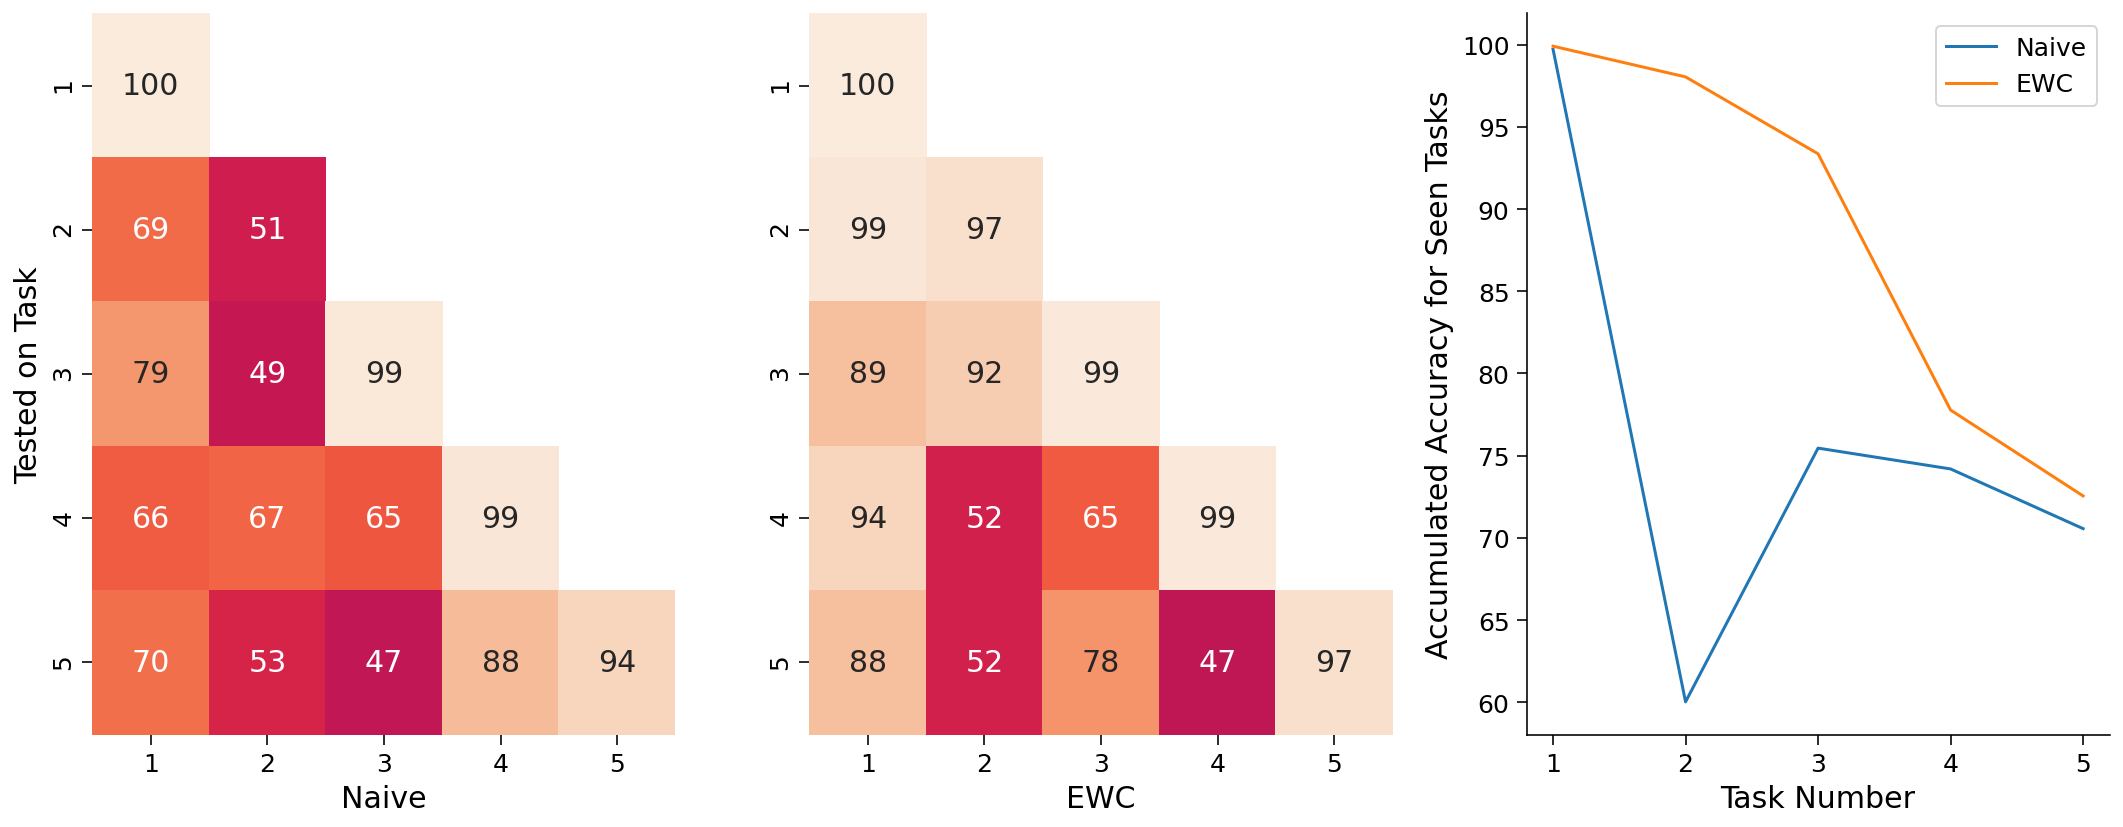

In [ ]:
#@title Plot Naive vs EWC results
import seaborn as sns

fig, axes = plt.subplots(1, 3, figsize=(15, 6))
accs_fine_grid = np.array(accs_naive)
nan_mask = np.isnan(accs_naive)

sns.heatmap(accs_naive, vmin=0, vmax=100, mask=nan_mask, annot=True,fmt='.0f',
            yticklabels=range(1, 6), xticklabels=range(1, 6), ax=axes[0], cbar=False)
sns.heatmap(accs_ewc, vmin=0, vmax=100, mask=nan_mask, annot=True,fmt='.0f',
            yticklabels=range(1, 6), xticklabels=range(1, 6), ax=axes[1], cbar=False)

axes[0].set_ylabel('Tested on Task')

axes[0].set_xlabel('Naive')
axes[1].set_xlabel('EWC')

axes[2].plot(range(1, 6), np.nanmean(accs_naive, axis=1))
axes[2].plot(range(1, 6), np.nanmean(accs_ewc, axis=1))

axes[2].legend(['Naive', 'EWC'])
axes[2].set_ylabel('Accumulated Accuracy for Seen Tasks')
axes[2].set_xlabel('Task Number')

END OF ALTERNATIVE SECTION 2

---
# Section 2: Continual Learning strategies

In this section we will take a look at some of the most prominent and basic continual learning strategies, namely, Rehearsal and Elastic Weight Consolidation (EWC).

To learn more about some of the popular CL strategies, check this [page](https://vlomonaco.github.io/core50/strategies.html#:~:text=Rehearsal%20Strategies%3A%20past%20information%20is,new%20patterns%20for%20future%20training.).

In [ ]:
#@title Video 2: Video 2 Name
# Insert the ID of the corresponding youtube video
from IPython.display import YouTubeVideo
video = YouTubeVideo(id="", width=854, height=480, fs=1)
print("Video available at https://youtu.be/" + video.id)
video

Video available at https://youtu.be/


## Rehearsal

Rehearsal is arguably the simplest CL strategy where one simply passes all or some samples from previous tasks in the current task mixed with samples of the current task. 
The performance scales proportionally to the number of samples replayed from previous tasks, however, comes at a cost of memory expense. 

To learn more about rehearsal, check out this [paper](https://arxiv.org/abs/1809.05922).

Before starting with the strategies, let's define our tasks using Split MNIST. We will create 5 tasks each containing 2 classes from the MNIST dataset. 

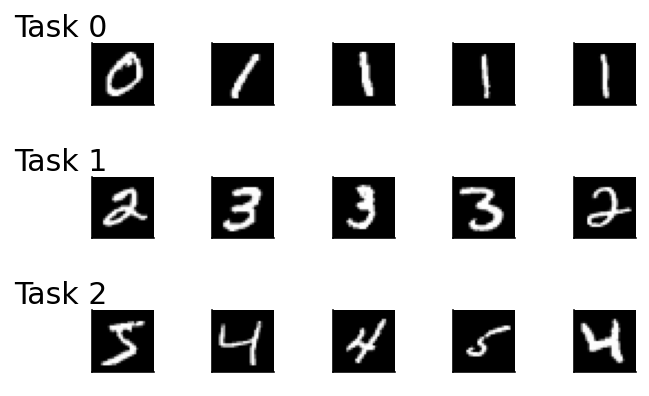

In [ ]:
# tasks to use
task_classes_arr = [(0, 1), (2, 3), (4, 5), (6, 7), (8, 9)]
tasks_num = len(task_classes_arr) # 5

task_data = []
task_data_with_overlap = []
for i, task_classes in enumerate(task_classes_arr):
  train_mask = np.isin(t_train, task_classes)
  test_mask = np.isin(t_test, task_classes)
  x_train_task, t_train_task = x_train[train_mask], t_train[train_mask]
  x_test_task, t_test_task = x_test[test_mask], t_test[test_mask]
  
  task_data.append((x_train_task, t_train_task, x_test_task, t_test_task))
  task_data_with_overlap.append((x_train_task, t_train_task - (i * 2),
                                 x_test_task, t_test_task - (i * 2)))

# Display tasks
n_tasks, samples = 3, 5
_, axs = plt.subplots(n_tasks, samples, figsize=(5, 3))
for task in range(n_tasks):
  axs[task, 0].set_ylabel(f'Task {task}', rotation=0)
  axs[task, 0].yaxis.set_label_coords(-0.5,1)
  plot_task(axs[task], task_data[task][0], samples)
plt.tight_layout()

First let's define the function `shuffle_in_unison` that would allow us to shuffle the samples from the previous task with that of the current task.

In [ ]:
def shuffle_in_unison(dataset, seed, in_place=False):
    """ Shuffle two (or more) list in unison. """

    np.random.seed(seed)
    rng_state = np.random.get_state()
    new_dataset = []
    for x in dataset:
        if in_place:
            np.random.shuffle(x)
        else:
            new_dataset.append(np.random.permutation(x))
        np.random.set_state(rng_state)

    if not in_place:
        return new_dataset

### Multi-Head Strategy

For this example, we shall be using the Multi-Head Rehearsal Strategy wherein we shall define a Base Net which will act as a simple feature extractor and will learn the common hidden representations across the tasks; and we will use a specific head for each task which would act as a classifier. 

To understand the Multi-Head strategy in context of our 5-task Split MNIST: We first train the model to identify 0 & 1 images then, when the second task comes, the model fine-tunes the hidden representation and creates a new head to identify 2 & 3 images. In the previous example, the model will keep track that 2 & 3 data belong to task #2 and it will expect to receive this information at test time to acquire the right head. This has the negative side effect of needing knowledge about what task a datapoint belongs to. However, this is particularly unrealistic in real-world scenarios.

In [ ]:
class FBaseNet(nn.Module):
  def __init__(self, hsize=512):
    super(FBaseNet, self).__init__()
    self.l1 = nn.Linear(784, hsize)

  def forward(self, x):
    x = x.view(x.size(0), -1)
    x = F.relu(self.l1(x))
    return x


class FHeadNet(nn.Module):
  def __init__(self, base_net, input_size=512):
    super(FHeadNet, self).__init__()

    self.base_net = base_net

    self.l1 = nn.Linear(input_size, 2)

  def forward(self, x):
    x = self.base_net.forward(x)
    x = self.l1(x)
    return x

In [ ]:
def train_multihead(past_examples_percentage=0, epochs=15):
  base = FBaseNet().to(device)
  heads = []

  accs_fine_grid = []

  for i in range(tasks_num):
    x_train, t_train, _, _ = task_data_with_overlap[i]
    model = FHeadNet(base).to(device)
    optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
    heads.append(model)

    # concatenate previous tasks
    for j in range(0, i + 1):
      past_x_train, past_t_train, _, _ = task_data_with_overlap[j]
      example_num = int(past_examples_percentage * len(past_t_train))
      x_train = np.concatenate((x_train, past_x_train[:example_num]))
      t_train = np.concatenate((t_train, past_t_train[:example_num]))

    x_train, t_train = shuffle_in_unison([x_train, t_train], 0)

    train(model, device, x_train, t_train, optimizer, epochs)
    # test on tasks seen so far
    accs_subset = []
    for j in range(0, i + 1):
      _, _, x_test, t_test = task_data_with_overlap[j]
      test_acc = test(heads[j], device, x_test, t_test)
      accs_subset.append(test_acc)

    if i < (tasks_num - 1):
      accs_subset.extend([np.nan] * (4 - i))
    
    accs_fine_grid.append(accs_subset)

  return accs_fine_grid

We shall train 3 different variants:
1. Naive - No samples from previous tasks are carried to the next task. (No Replay)
2. Complete Rehearsal - All samples from previous tasks are carried to the next task.
3. Partial Rehearsal - *x*% of samples from the previous tasks are carried to the next task. In this example, we use 5% of samples from the previous tasks for replay. 

In [ ]:
accs_naive = train_multihead(epochs=15)
accs_rehearsal_all = train_multihead(1, epochs=15)
accs_rehearsal_5 = train_multihead(0.05, epochs=15)

Train Epoch: 15 	Loss: 0.149701
Test set: Average loss: 0.0000, Accuracy: 2108/2115 (100%)

Train Epoch: 15 	Loss: 2.918180
Test set: Average loss: 0.0001, Accuracy: 1686/2115 (80%)

Test set: Average loss: 0.0001, Accuracy: 1066/2042 (52%)

Train Epoch: 15 	Loss: 0.353009
Test set: Average loss: 0.0001, Accuracy: 1152/2115 (54%)

Test set: Average loss: 0.0001, Accuracy: 1299/2042 (64%)

Test set: Average loss: 0.0000, Accuracy: 1792/1874 (96%)

Train Epoch: 15 	Loss: 0.690787
Test set: Average loss: 0.0001, Accuracy: 1162/2115 (55%)

Test set: Average loss: 0.0001, Accuracy: 1010/2042 (49%)

Test set: Average loss: 0.0001, Accuracy: 898/1874 (48%)

Test set: Average loss: 0.0001, Accuracy: 1047/1986 (53%)

Train Epoch: 15 	Loss: 0.671516
Test set: Average loss: 0.0001, Accuracy: 1219/2115 (58%)

Test set: Average loss: 0.0001, Accuracy: 1048/2042 (51%)

Test set: Average loss: 0.0001, Accuracy: 899/1874 (48%)

Test set: Average loss: 0.0001, Accuracy: 1058/1986 (53%)

Test set: Avera

Text(0.5, 12.199999999999974, 'Task Number')

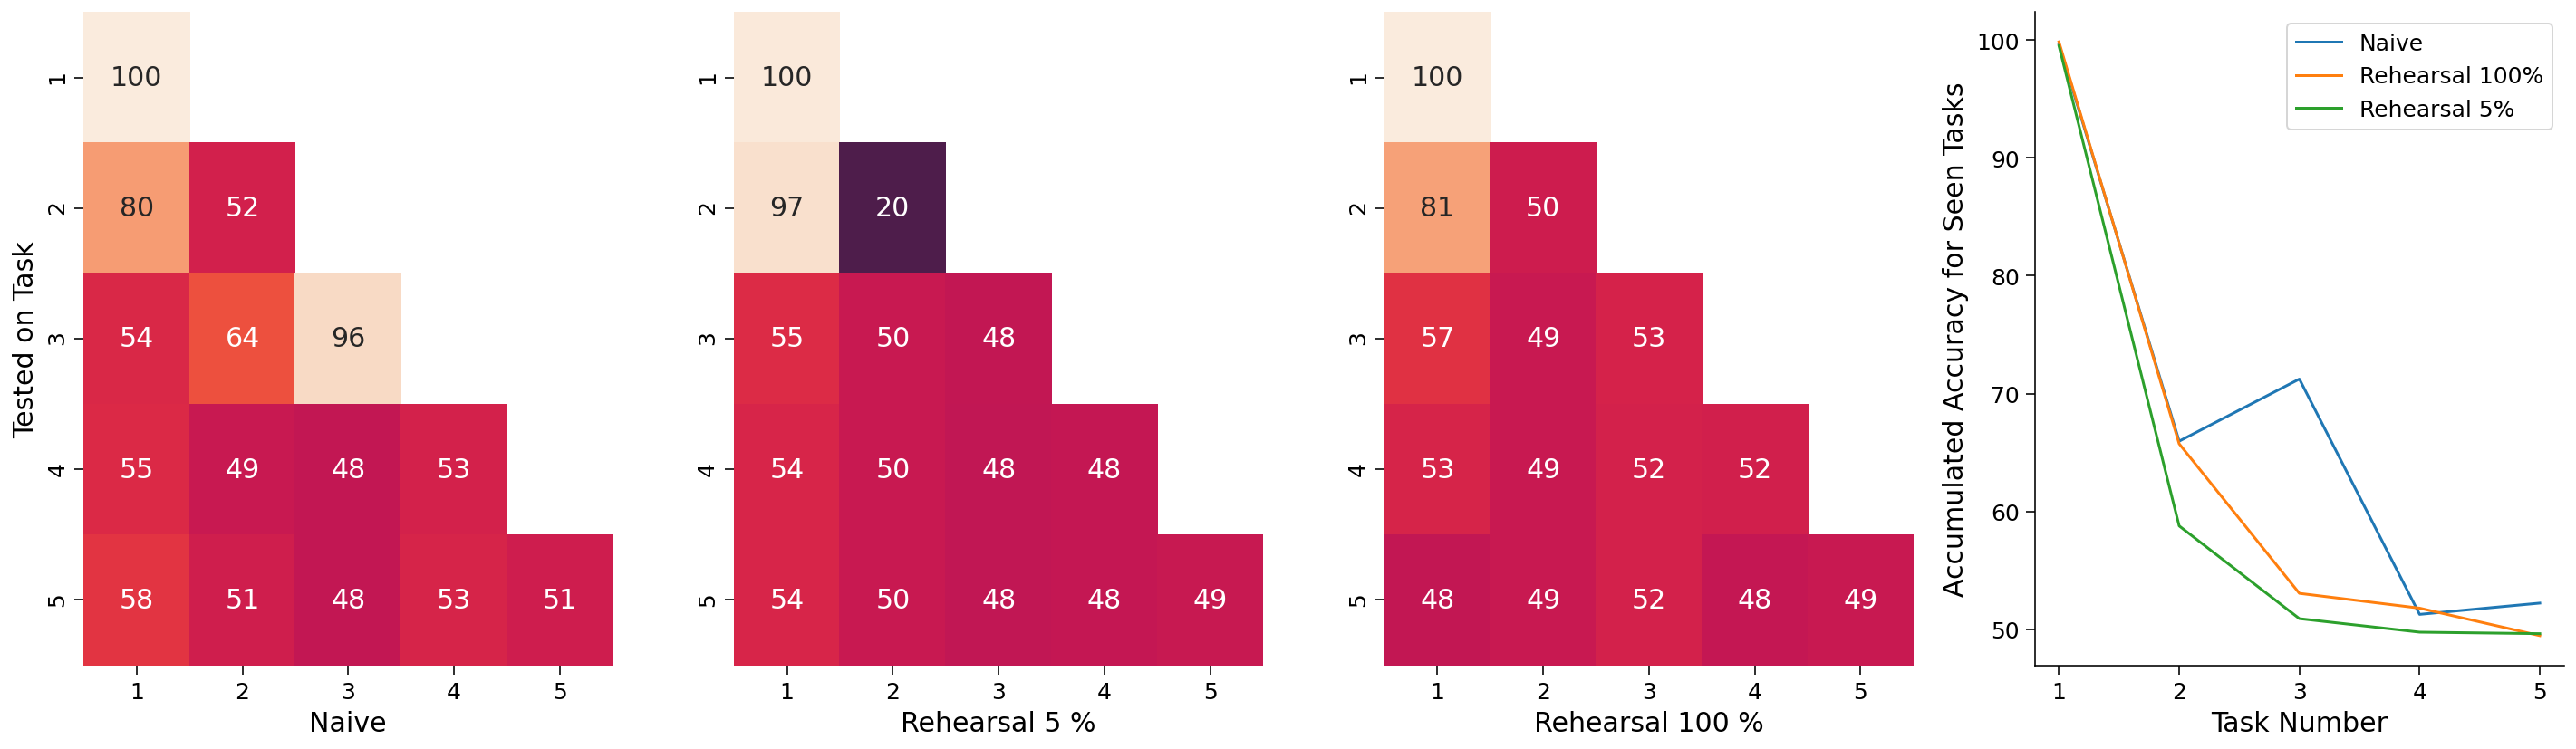

In [ ]:
#@title Plot Multihead replay results
import seaborn as sns

fig, axes = plt.subplots(1, 4, figsize=(20, 6))
accs_fine_grid = np.array(accs_naive)
nan_mask = np.isnan(accs_naive)

sns.heatmap(accs_naive, vmin=0, vmax=100, mask=nan_mask, annot=True,fmt='.0f',
            yticklabels=range(1, 6), xticklabels=range(1, 6), ax=axes[0], cbar=False)
sns.heatmap(accs_rehearsal_5, vmin=0, vmax=100, mask=nan_mask, annot=True,fmt='.0f',
            yticklabels=range(1, 6), xticklabels=range(1, 6), ax=axes[1], cbar=False)
sns.heatmap(accs_rehearsal_all, vmin=0, vmax=100, mask=nan_mask, annot=True,  fmt='.0f',
            yticklabels=range(1, 6), xticklabels=range(1, 6), ax=axes[2], cbar=False)

axes[0].set_ylabel('Tested on Task')

axes[0].set_xlabel('Naive')
axes[1].set_xlabel('Rehearsal 5 %')
axes[2].set_xlabel('Rehearsal 100 %')


axes[3].plot(range(1, 6), np.nanmean(accs_naive, axis=1))
axes[3].plot(range(1, 6), np.nanmean(accs_rehearsal_all, axis=1))
axes[3].plot(range(1, 6), np.nanmean(accs_rehearsal_5, axis=1))

axes[3].legend(['Naive', 'Rehearsal 100%', 'Rehearsal 5%'])
axes[3].set_ylabel('Accumulated Accuracy for Seen Tasks')
axes[3].set_xlabel('Task Number')

With the multi-head setting all the strategies maintains a good performance on previous tasks, especially using a simple network. This highlights the unrealistic assumptions behind Multi-Head, which is able to tackle catastrophic forgetting effectively even without any CL strategy. As we already explained, however, multi-head setting is a very unrealistic CL scenario.

However as discussed at the start, the downside of using such replay methods is the high memory cost depending on the number of samples carried ahead from the previous task. 

Here are some follow-up questions to brainstorm on:

1. Can we make Rehearsal more memory efficient?

2. What's a good trade-off between the memory overhead induced by samples from the previous tasks and overall accuracy?

## Elastic Weight Consolidation (EWC)

EWC is a foundational CL strategy which involves computing the importance of weights of the network relative to the task using the Fisher score and then penalizing the network for changes to the most important weights of the previous task. 

It was introduced in the paper "[Overcoming catastrophic forgetting in neural networks
](https://arxiv.org/abs/1612.00796)". 

The main adavantage of using EWC over Rehearsal is that EWC does not require any data of the previous tasks to be replayed again. 

First let's creare the dictionaries to store the fisher scores.

In [ ]:
fisher_dict = {}
optpar_dict = {}

In [ ]:
model = Net().to(device)
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)

Now we need to define an additional function to compute the fisher information for each weight at the end of each task:

In [ ]:
def on_task_update(task_id, x_mem, t_mem):

  model.train()
  optimizer.zero_grad()
  
  # accumulating gradients
  for start in range(0, len(t_mem)-1, 256):
      end = start + 256
      x = torch.from_numpy(x_train[start:end]).type(torch.cuda.FloatTensor)
      y = torch.from_numpy(t_train[start:end]).long()
      x, y = x.to(device), y.to(device)
      output = model(x)
      loss = F.cross_entropy(output, y)
      loss.backward()

  fisher_dict[task_id] = {}
  optpar_dict[task_id] = {}

  # gradients accumulated can be used to calculate fisher
  for name, param in model.named_parameters():
    
    optpar_dict[task_id][name] = param.data.clone()
    fisher_dict[task_id][name] = param.grad.data.clone().pow(2)

We need also to modify our train function to add the new regularization loss:

In [ ]:
def train_ewc(model, device, task_id, x_train, t_train, optimizer, epoch, ewc_lambda):
    model.train()

    for start in range(0, len(t_train)-1, 256):
      end = start + 256
      x = torch.from_numpy(x_train[start:end]).type(torch.cuda.FloatTensor)
      y = torch.from_numpy(t_train[start:end]).long()
      x, y = x.to(device), y.to(device)
      
      optimizer.zero_grad()

      output = model(x)
      loss = F.cross_entropy(output, y)
      
      ### magic here! :-)
      for task in range(task_id):
        for name, param in model.named_parameters():
          fisher = fisher_dict[task][name]
          optpar = optpar_dict[task][name]
          loss += (fisher * (optpar - param).pow(2)).sum() * ewc_lambda
      
      loss.backward()
      optimizer.step()
      #print(loss.item())
    print('Train Epoch: {} \tLoss: {:.6f}'.format(epoch, loss.item()))

Finally we can run the train over the three tasks sequence of Permuted MNIST:

In [ ]:
def ewc(ewc_lambda = 0.4):
  ewc_strat = []

  for id, task in enumerate(task_data):
    avg_acc = 0
    print("Training on task: ", id)
    
    x_train, t_train, _, _ = task
    
    for epoch in range(1, 3):
      train_ewc(model, device, id, x_train, t_train, optimizer, epoch, ewc_lambda)
    on_task_update(id, x_train, t_train)
      
    for id_test, task in enumerate(task_data):
      print("Testing on task: ", id_test)
      _, _, x_test, t_test = task
      acc = test(model, device, x_test, t_test)
      avg_acc = avg_acc + acc
    
    print("Avg acc: ", avg_acc / 3)
    ewc_strat.append(avg_acc / 3)
    
  return ewc_strat

In [ ]:
ewc_1 = ewc(ewc_lambda = 0.4)
ewc_2 = ewc(ewc_lambda = 0.6)

Training on task:  0
Train Epoch: 1 	Loss: nan
Train Epoch: 2 	Loss: nan
Testing on task:  0
Test set: Average loss: nan, Accuracy: 980/2115 (46%)

Testing on task:  1
Test set: Average loss: nan, Accuracy: 0/2042 (0%)

Testing on task:  2
Test set: Average loss: nan, Accuracy: 0/1874 (0%)

Testing on task:  3
Test set: Average loss: nan, Accuracy: 0/1986 (0%)

Testing on task:  4
Test set: Average loss: nan, Accuracy: 0/1983 (0%)

Avg acc:  15.445232466509061
Training on task:  1
Train Epoch: 1 	Loss: nan
Train Epoch: 2 	Loss: nan
Testing on task:  0
Test set: Average loss: nan, Accuracy: 980/2115 (46%)

Testing on task:  1
Test set: Average loss: nan, Accuracy: 0/2042 (0%)

Testing on task:  2
Test set: Average loss: nan, Accuracy: 0/1874 (0%)

Testing on task:  3
Test set: Average loss: nan, Accuracy: 0/1986 (0%)

Testing on task:  4
Test set: Average loss: nan, Accuracy: 0/1983 (0%)

Avg acc:  15.445232466509061
Training on task:  2
Train Epoch: 1 	Loss: nan
Train Epoch: 2 	Loss: n

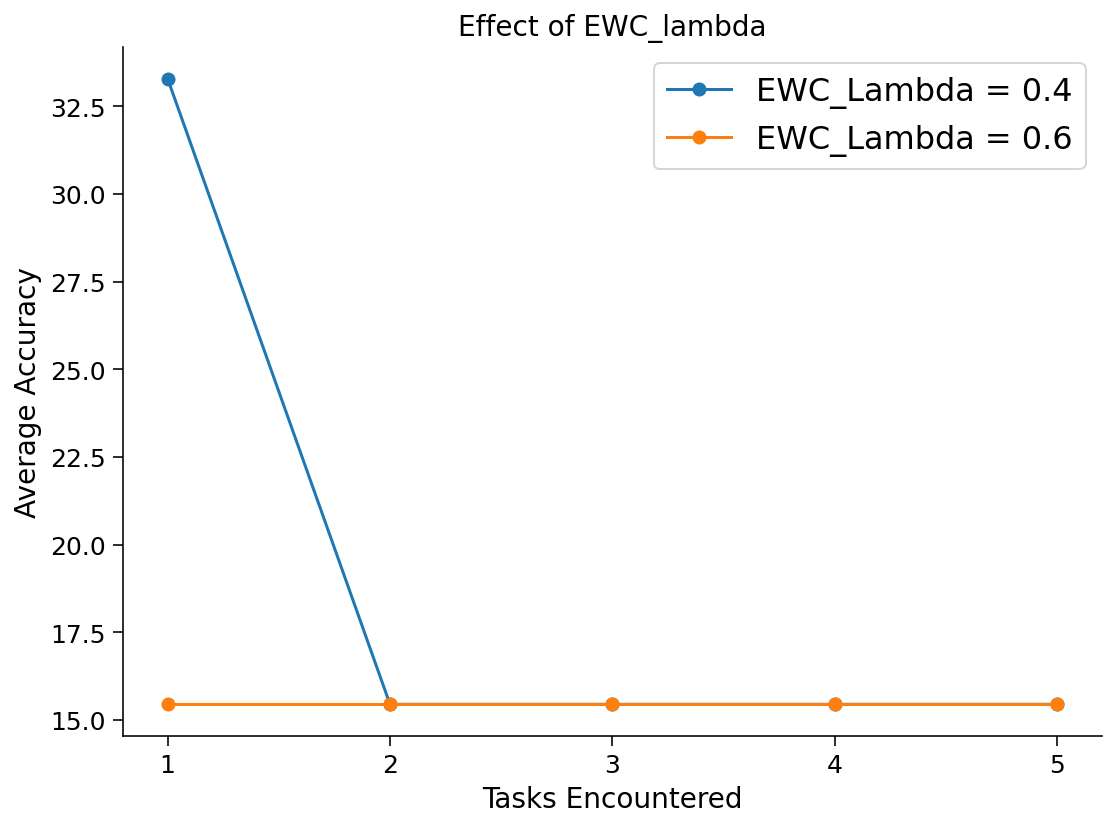

In [ ]:
#@title Plot EWC Results
plt.plot([1,2,3,4,5], ewc_1, '-o', label="EWC_Lambda = 0.4")
plt.plot([1,2,3,4,5], ewc_2, '-o', label="EWC_Lambda = 0.6")
plt.xlabel('Tasks Encountered', fontsize=14)
plt.ylabel('Average Accuracy', fontsize=14)
plt.title('Effect of EWC_lambda', fontsize=14);
plt.xticks([1, 2, 3, 4, 5])
plt.legend(prop={'size': 16});

However, there are still some questions that are left to be answered for the efficiency of EWC. We will let you get hands on to answer the same in the next exercise.

## Exercise 2: Test out three different lambda values for 

EWC and observe their performance.



### Exercise 2: Name

---
# Section 3: Continual learning benchmarks

In this section, we will introduce different ways in which a continual learning problem could be set up.

In [ ]:
#@title Video 3: Benchmarks and different types of continual learning
# Insert the ID of the corresponding youtube video
from IPython.display import YouTubeVideo
video = YouTubeVideo(id="", width=854, height=480, fs=1)
print("Video available at https://youtu.be/" + video.id)
video

Video available at https://youtu.be/


As introduced in the above video, continual learning research certainly does not only use the MNIST dataset.
But to make things not more complicated than necessary (and to make sure the examples run in an acceptable amount of time), we continue with the Split MNIST example for now.
At the end of this notebook we will take a sneak peak at the CORe50 dataset.

## Task-incremental Split MNIST *versus* class-incremental Split MNIST

First, let's identify according to which scenario the Split MNIST problem in the previous section was performed.

Recall that the Split MNIST problem consists of five tasks, whereby each task contains two digits. In the previous section, the model was set-up in such a way that it had a separate output layer for each of these tasks (this is typically called a 'multi-headed output layer'). At test time, the model then used the output layer of the task to which the example to be classified belonged. This means that it was assumed that the model always knows which task it must performed, so this was an example of **task-incremental learning**.

In the continual learning literature, a multi-headed output layer is probably the most common way to use task identity information, but it is certainly not the only way (for example, see [this paper](https://doi.org/10.1073/pnas.1803839115)).

Now, let's reorganize the above Split MNIST problem to set it up as a **class-incremental learning** problem. That is, task information is no longer provided to the model; the model must be able to decide itself to which task a test sample belongs.
This means that, after all tasks have been learned, the model must now choose between all ten digits.

In [ ]:
# Load the MNIST dataset
x_train, t_train, x_test, t_test = load_mnist(verbose=True)

# Define which classes are part of each task
classes_per_task = [(0, 1), (2, 3), (4, 5), (6, 7), (8, 9)]

# Divde the MNIST dataset in tasks
task_data = []
for _, classes_in_this_task in enumerate(classes_per_task):
  
  # Which data-points belong to the classes in the current task?
  train_mask = np.isin(t_train, classes_in_this_task)
  test_mask = np.isin(t_test, classes_in_this_task)
  x_train_task, t_train_task = x_train[train_mask], t_train[train_mask]
  x_test_task, t_test_task = x_test[test_mask], t_test[test_mask]

  # Add the data for the current task
  task_data.append((x_train_task, t_train_task, x_test_task, t_test_task))

# In contrast to the task-incremental version of Split MNIST explored in the
# last section, now task identity information will not be provided to the model

x_train dim and type:  (60000, 1, 28, 28) uint8
t_train dim and type:  (60000,) int64
x_test dim and type:  (10000, 1, 28, 28) uint8
t_test dim and type:  (10000,) int64



## Example: EWC on the class-incremental version of Split MNIST

Let's now try the EWC method on this class-incremental version of Split MNIST.

In [ ]:
# Define the model and the optimzer
model = Net().to(device)
optimizer = optim.SGD(model.parameters(), lr=0.001)

# Set 'lambda', the hyperparameter of EWC
ewc_lambda = 0.4

# Define dictionaries to store values needed by EWC
fisher_dict = {}
optpar_dict = {}

# Prepare list to store average accuracies after each task
ewc_accs = []

# Loop through all tasks
for id, task in enumerate(task_data):

  # Collect training data
  x_train, t_train, _, _ = task

  # Training with EWC
  print("Training on task: ", id)
  for epoch in range(1, 2):
    train_ewc(model, model, device, id, x_train, t_train, optimizer, epoch,
              ewc_lambda, fisher_dict, optpar_dict)
  on_task_update(id, x_train, t_train, model, model, fisher_dict,
                 optpar_dict)
  
  # Evaluate performance after training on this task
  avg_acc = 0
  for id_test, task in enumerate(task_data):
    print("Testing on task: ", id_test)
    _, _, x_test, t_test = task
    acc = test(model, device, x_test, t_test)
    avg_acc = avg_acc + acc
   
  print("Avg acc: ", avg_acc / len(task_data))
  ewc_accs.append(avg_acc / len(task_data))

Training on task:  0
Train Epoch: 1 	Loss: 0.270196
Testing on task:  0
Test set: Average loss: 0.0000, Accuracy: 2112/2115 (100%)

Testing on task:  1
Test set: Average loss: 0.0092, Accuracy: 0/2042 (0%)

Testing on task:  2
Test set: Average loss: 0.0086, Accuracy: 0/1874 (0%)

Testing on task:  3
Test set: Average loss: 0.0103, Accuracy: 0/1986 (0%)

Testing on task:  4
Test set: Average loss: 0.0095, Accuracy: 0/1983 (0%)

Avg acc:  19.97163120567376
Training on task:  1
Train Epoch: 1 	Loss: 0.931217
Testing on task:  0
Test set: Average loss: 0.0021, Accuracy: 51/2115 (2%)

Testing on task:  1
Test set: Average loss: 0.0003, Accuracy: 1767/2042 (87%)

Testing on task:  2
Test set: Average loss: 0.0056, Accuracy: 0/1874 (0%)

Testing on task:  3
Test set: Average loss: 0.0056, Accuracy: 0/1986 (0%)

Testing on task:  4
Test set: Average loss: 0.0053, Accuracy: 0/1983 (0%)

Avg acc:  17.78883169747362
Training on task:  2
Train Epoch: 1 	Loss: 1.467653
Testing on task:  0
Test set

That didn't work well...

The model only correctly predicts the classes from the last task it has seen, all earlier seen classes seem to be forgotten.

You might wonder whether the reason that EWC performed so badly in the above example is because we chose an unsuitable value for the hyperparameter lambda.
Although we don't have time to demonstrate this, there are no values of lambda that would lead to good performance.

In general, parameter regularization based methods, such as EWC, have been found not to work well on class-incremental learning problems, as for example illustrated in [this paper](https://arxiv.org/abs/1904.07734).

## Replay

As dicsussed in the lecture of the previous section, another popular continual learning strategy is replay. Let's see whether replay works better on the class-incremental learning version of Split MNIST than EWC did.

One implementation of replay is to simply store all data from previously seen tasks, and to then, whenever a new task must be learned, mix in that stored data with the training data of the new task.

To achieve this form of replay, let's define the following function for shuffling multiple datasets (e.g., the data from previous tasks with the data from the current task) together:

In [ ]:
def shuffle_in_unison(dataset, seed, in_place=False):
    """ Shuffle two (or more) list in unison. """

    np.random.seed(seed)
    rng_state = np.random.get_state()
    new_dataset = []
    for x in dataset:
        if in_place:
            np.random.shuffle(x)
        else:
            new_dataset.append(np.random.permutation(x))
        np.random.set_state(rng_state)

    if not in_place:
        return new_dataset

Note that this form of replay is somewhat extreme, as it stores all the training data from previous tasks. In practice, replay is often implemented in ways that store less data, for example either by using relatively small memory buffers (see [this paper](https://arxiv.org/abs/1902.10486)) or by learning a generative model to then generate the data to be replayed (see [this paper](https://arxiv.org/abs/1705.08690) or [this paper](https://www.nature.com/articles/s41467-020-17866-2)).

## Example: Test replay on the class-incremental version of Split MNIST

Let's try whether this replay strategy works better than EWC.

In [ ]:
# Define the model and the optimizer
model = Net().to(device)
optimizer = optim.SGD(model.parameters(), lr=0.01)

# Prepare list to store average accuracies after each task
rehe_accs = []

# Loop through all tasks
for id, task in enumerate(task_data):
  
  # Collect training data
  x_train, t_train, _, _ = task
  
  # Add replay
  for i in range(id):
    past_x_train, past_t_train, _, _ = task_data[i]
    x_train = np.concatenate((x_train, past_x_train))
    t_train = np.concatenate((t_train, past_t_train))
  x_train, t_train = shuffle_in_unison([x_train, t_train], 0)
  
  # Training
  print("Training on task: ", id)
  for epoch in range(1, 3):
    train(model, device, x_train, t_train, optimizer, epoch)
  
  # Evaluate performance after training on this task
  avg_acc = 0
  for id_test, task in enumerate(task_data):
    print("Testing on task: ", id_test)
    _, _, x_test, t_test = task
    acc = test(model, device, x_test, t_test)
    avg_acc = avg_acc + acc
   
  print("Avg acc: ", avg_acc / len(task_data))
  rehe_accs.append(avg_acc/len(task_data))

Training on task:  0
Train Epoch: 1 	Loss: 0.027203
Train Epoch: 2 	Loss: 0.009466
Testing on task:  0
Test set: Average loss: 0.0000, Accuracy: 2111/2115 (100%)

Testing on task:  1
Test set: Average loss: 0.0108, Accuracy: 0/2042 (0%)

Testing on task:  2
Test set: Average loss: 0.0103, Accuracy: 0/1874 (0%)

Testing on task:  3
Test set: Average loss: 0.0126, Accuracy: 0/1986 (0%)

Testing on task:  4
Test set: Average loss: 0.0113, Accuracy: 0/1983 (0%)

Avg acc:  19.962174940898343
Training on task:  1
Train Epoch: 1 	Loss: 0.293769
Train Epoch: 2 	Loss: 0.270502
Testing on task:  0
Test set: Average loss: 0.0000, Accuracy: 2095/2115 (99%)

Testing on task:  1
Test set: Average loss: 0.0000, Accuracy: 1980/2042 (97%)

Testing on task:  2
Test set: Average loss: 0.0038, Accuracy: 0/1874 (0%)

Testing on task:  3
Test set: Average loss: 0.0033, Accuracy: 0/1986 (0%)

Testing on task:  4
Test set: Average loss: 0.0035, Accuracy: 0/1983 (0%)

Avg acc:  39.203626908213565
Training on t

And finally, let's compare the performance of EWC and Replay on the class-incremental version of Split MNIST in a plot:

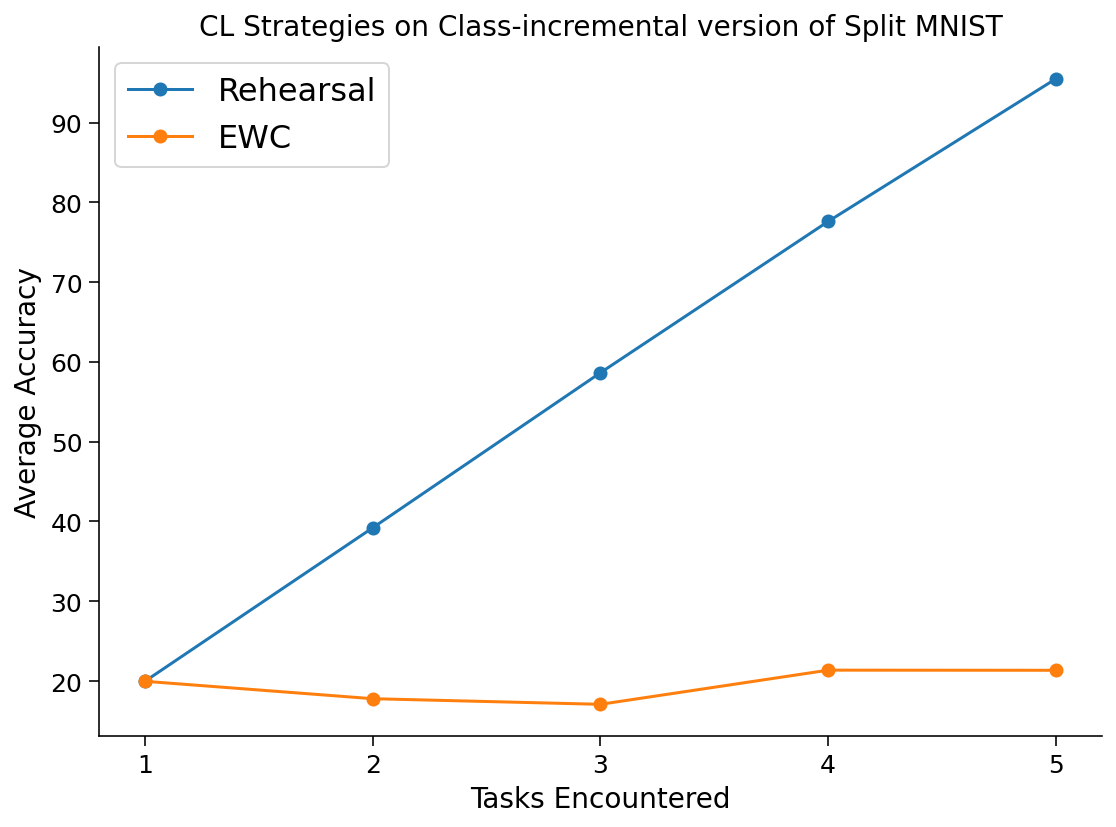

In [ ]:
#@title Plot EWC vs replay
plt.plot([1, 2, 3, 4, 5], rehe_accs, '-o', label="Rehearsal")
plt.plot([1, 2, 3, 4, 5], ewc_accs, '-o', label="EWC")
plt.xlabel('Tasks Encountered', fontsize=14)
plt.ylabel('Average Accuracy', fontsize=14)
plt.title('CL Strategies on Class-incremental version of Split MNIST',
          fontsize=14);
plt.xticks([1, 2, 3, 4, 5])
plt.legend(prop={'size': 16});

## Exercise: Identify the scenario of the permuted MNIST example from Section 1

What type of 'scenario' was the permuted MNIST problem that was introduced in Section 1? Was it task-incremental, domain-incremental or class-incremental? Try to motivate your answer.

In [ ]:
# to_remove explanation

'''
The Permuted MNIST problem in Section 1 is an example of domain-incremental
learning.

Recall that this problem consisted of two tasks: normal MNIST (task 1) and MNIST
with permuted input images (task 2).
After learning both task, when the model is evaluated, the model is not told to
which task an image belongs (i.e., the model is not told whether the image be
classified is permuted or not), but the model also does not need to identify to
which task an image belongs (i.e., the model does not need to predict whether
the image to be classified has permuted pixels or not; it only needs to predict
the original digit displayed in the image).

Another way to motivate that this problem is an example of domain-incremental
learning, is to say that in both task 1 (normal MNIST) and task 2 (MNIST with
permuted input images), the 'type of problem' is the same (i.e., identify the
digit displayed in the original image), but the 'context' is changing (i.e.,
the order in which the image pixels are presented).
''';

---
# Section 4: Evaluation of continual learning algorithms

Understanding how your CL algorithm is performing is key to gain insights on its behavior and to decide how to improve it. 

Here, we will focus on how to build some of the most important CL metrics!

In [ ]:
#@title Video 2: Continual Learning Evaluation
# Insert the ID of the corresponding youtube video
from IPython.display import YouTubeVideo
video = YouTubeVideo(id="", width=854, height=480, fs=1)
print("Video available at https://youtu.be/" + video.id)
video

We have already trained the model on T tasks and recorded all the accuracy values in a single TxT matrix.

## Average Accuracy

The Average Accuracy (ACC) metric computes the average accuracy over all tasks after training on all tasks.

In [ ]:
def ACC(result_matrix):
  """
  Average Accuracy metric

  :param result_matrix: TxT matrix containing accuracy values in each (i, j) entry.
    (i, j) -> test accuracy on task j after training on task i
  """

  final_accs = result_matrix[-1, :]  # take accuracies after final training
  acc = np.mean(final_accs)  # compute average
  return acc, final_accs

## Backward Transfer

The Backward Transfer (BWT) metric of task i computes the accuracy on task i after training on last task **minus** the accuracy on task i after training on task i.

To get the average BWT you have to average across all tasks.

**Negative BWT expresses the amount of forgetting suffered by the algorithm.**


In [ ]:
def BWT(result_matrix):
  """
  Backward Transfer metric

  :param result_matrix: TxT matrix containing accuracy values in each (i, j) entry.
    (i, j) -> test accuracy on task j after training on task i
  """

  final_accs = result_matrix[-1, :]  # take accuracies after final training
  # accuracies on task i right after training on task i, for all i
  training_accs = np.diag(result_matrix)  
  task_bwt = final_accs - training_accs  # BWT for each task
  average_bwt = np.mean(task_bwt)  # compute average
  return average_bwt, task_bwt

## Exercise: evaluate your CL algorithm on a benchmark

You should replace the `None` values with your code. This is the only cell you have to modify :)

In [ ]:
def train_model():
  """Train a model with a replay strategy on Split MNIST by using the multi-head.
     The benchmark will have 5 tasks.

  Returns:
    result_matrix: TxT matrix of accuracies. Each (i,j) element is the accuracy
        on task j after training on task i
  """
  #################################################
  ##  ##
  # Fill out function and remove
  raise NotImplementedError("You should train a model on Split MNIST with replay"
                             "and multi-head. You should return the matrix of accuracies"
                             "of all tasks after training on each task.")
  
  model = Net().to(device)
  optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)  
  criterion = nn.CrossEntropyLoss()

  # train the model (insert percentage and epochs)
  result_matrix = train_multihead(past_examples_percentage=None, epochs=None)

  return np.array(result_matrix)

In [ ]:
#to_remove solution

def train_model():
  """Train a model with a CL algorithm of your choice on a chosen CL benchmark.
     The benchmark will have T tasks.

  Returns:
    result_matrix: TxT matrix of accuracies. Each (i,j) element is the accuracy
        on task j after training on task i
  """
  #################################################
  
  model = Net().to(device)
  optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)  
  criterion = nn.CrossEntropyLoss()
  
  benchmark = None  # define your CL benchmark

  # train the model on the benchmark with the strategy and get the result

  result_matrix = train_multihead(past_examples_percentage=0.5, epochs=10)

  return np.array(result_matrix)

In [ ]:
#to_remove explanation
"""
As we discussed, the number of metrics you can evaluate is very large. To keep things compact,
we only focus on 2 performance metrics. You can have fun and implement the forward transfer :)

Result matrix have nan values in correspondence of future tasks since we do not evaluate our
model on future tasks.
"""

'\nAs we discussed, the number of metrics you can evaluate is very large. To keep things compact,\nwe only focus on 2 performance metrics. You can have fun and implement the forward transfer :)\n\nResult matrix have nan values in correspondence of future tasks since we do not evaluate our\nmodel on future tasks.\n'

You **don't** need to modify the next cell, just execute it to see metrics in action!

In [ ]:
# here compute the result matrix containing all the accuracy values on a strategy
# and CL benchmark of your choice. 
result_matrix = train_model()

if result_matrix is None or n_tasks is None:
  raise ValueError("You should fill the values of `result_matrix`, `n_tasks` and `random_acc` first.")

print("Result matrix shape: ", result_matrix.shape)
print("Result matrix values: ", result_matrix)

# print Average Accuracy metric
acc, final_accs = ACC(result_matrix)
print("ACC: ", acc)
print("Accuracies for each task: ",  final_accs)
print()

# print Backward Transfer metric
bwt, bwt_task = BWT(result_matrix)
print("BWT: ", bwt)
print("BWT for each task: ", bwt_task)
print()

Train Epoch: 10 	Loss: 0.000000
Test set: Average loss: 0.0003, Accuracy: 2113/2115 (100%)

Train Epoch: 10 	Loss: 0.857133
Test set: Average loss: 0.0005, Accuracy: 2027/2115 (96%)

Test set: Average loss: 0.0001, Accuracy: 1564/2042 (77%)

Train Epoch: 10 	Loss: 0.468857
Test set: Average loss: 0.0025, Accuracy: 648/2115 (31%)

Test set: Average loss: 0.0001, Accuracy: 1222/2042 (60%)

Test set: Average loss: 0.0001, Accuracy: 1351/1874 (72%)

Train Epoch: 10 	Loss: 0.410126
Test set: Average loss: 0.0017, Accuracy: 1153/2115 (55%)

Test set: Average loss: 0.0003, Accuracy: 1012/2042 (50%)

Test set: Average loss: 0.0001, Accuracy: 953/1874 (51%)

Test set: Average loss: 0.0000, Accuracy: 1581/1986 (80%)

Train Epoch: 10 	Loss: 0.692739
Test set: Average loss: 0.0006, Accuracy: 1146/2115 (54%)

Test set: Average loss: 0.0001, Accuracy: 1013/2042 (50%)

Test set: Average loss: 0.0001, Accuracy: 897/1874 (48%)

Test set: Average loss: 0.0001, Accuracy: 961/1986 (48%)

Test set: Average

---
# Section 5: Continual Learning Applications

Continual Learning with deep architectures may help us develop sustainable AI systems that can efficiently improve their skills and knowledge over time, adapting to ever-changing environments and learning objectives. In this section we will discuss about intriguing real-world applications that would highly benefit from recent advances in Continual Learning.

In [ ]:
#@title Video 2: Continual Learning Applications
# Insert the ID of the corresponding youtube video
from IPython.display import YouTubeVideo
video = YouTubeVideo(id="", width=854, height=480, fs=1)
print("Video available at https://youtu.be/" + video.id)
video

Video available at https://youtu.be/


**CORe50** is an interesting rea-world video dataset composed of 50 domestic objects belonging to 10 different categories and specifically designed for Continual Learning. You can find more information about the dataset and benchmark in its [official website](https://vlomonaco.github.io/core50). 

Here we will use the [Avalanche library](https://avalanche.continualai.org) to automatically download and use this dataset. Avalanche allows you to explore more challenging datasets and tasks to bring your continual learning algorithms into the real-world!

In [ ]:
pip install git+https://github.com/ContinualAI/avalanche.git

  Cloning https://github.com/ContinualAI/avalanche.git to /tmp/pip-req-build-dobp0nko
  Running command git clone -q https://github.com/ContinualAI/avalanche.git /tmp/pip-req-build-dobp0nko
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
     |████████████████████████████████| 276kB 30.4MB/s 
     |████████████████████████████████| 532kB 37.4MB/s 
     |████████████████████████████████| 1.8MB 30.3MB/s 
     |████████████████████████████████| 174kB 58.0MB/s 
     |████████████████████████████████| 133kB 52.4MB/s 
     |████████████████████████████████| 102kB 14.6MB/s 
     |████████████████████████████████| 71kB 11.2MB/s 
  Created wheel for avalanche: filename=avalanche-0.0.1-cp37-none-any.whl size=343970 sha256=4cb69ce2145eebaf6df9289e57d7394b76912628426c1b7ae9168ba0d11484ee
  Stored in directory: /tmp/pip-ephem-wheel-cache-5yeozcv3/wheels/45/3e/b7/1d78eeb6c42557cc5b6d727b2fed5b8ed3895bbcd23d9b6d29
Successfu

In [ ]:
from avalanche.benchmarks.classic import CORe50
# the scenario "New Instances" (NI) corresponds to the previously introduced 
# Domain-Incremental setting and its based on the idea of encounterning images
# of the same classes for every incremental batch of data (or experience if you 
# will). The "mini" option downloads data 32x32 instead of the original 128x128. 
benchmark = CORe50(root="/content/core50/", scenario="ni", mini=True)

Directory %s already exists /content/core50/


In [ ]:
for exp in benchmark.train_stream:
    print(exp.classes_in_this_experience)

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49]
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49]
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49]
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49]
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49]
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13

## Exercise 5: Explore the challenging CORe50 scenarios!

CORe50 offers and number of interesting preset scenarios already implemented and available to you through Avalanche. 

In this exercise try to explore the different scenarios offered (like the challenging NICv2-391) and possibly even apply what you've previously learned (like a replay approach) to get the best accuracy you can!

---
# Bonus

Add extra text that you want students to have for reference later but that will make reading times too long during tutorials

In [ ]:
# should probably hint at Avalanche at least

In [ ]:
# Free up resources when done :)

import os, signal
os.kill(os.getpid(), signal.SIGKILL)